In [1]:
import pandas as pd
import numpy as np
import os,glob
from matplotlib import pyplot as plt

Joey's code but modified to do any number of topics

# run a random forest on these words and see how well it can identify labels

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
glob.glob('../../third*.json')

['../../third_encoded_LDA_with_topics.json']

In [4]:
df = pd.read_json('../../third_encoded_LDA_with_topics.json')

In [5]:
#get the feature columns: those that start with 'key_word:'
feat = [x for x in df.columns if x[:9] == 'key_word:']
len(feat)

13272

# choose topics to classify

In [6]:
topics = ['hope','home','missionary work']
sizes = []
for topic in topics:
    temp = df.loc[df[topic] == 1].shape[0]
    sizes.append(temp)
    print('the topic',topic,'has',temp,'talks associated')

the topic hope has 42 talks associated
the topic home has 77 talks associated
the topic missionary work has 145 talks associated


In [7]:
# make an even dataset
resized_dfs = []
for topic in topics:
    resized = df.loc[df[topic] == 1].iloc[:np.array(sizes).min()].copy()
    resized_dfs.append(resized)
    print(resized.shape[0], end=' ')
new = pd.concat(resized_dfs)

42 42 42 

In [8]:
new.shape

(126, 13583)

# are there any instances that are both topics

In [9]:
topic_sum = sum(new[topic] for topic in topics)
remove_ind = new[topic_sum > 1].index
if len(remove_ind) > 0:
    print(len(remove_ind))
    new.drop(index=remove_ind,inplace=True)

5


# reduce the feature to where only these talks have these words so there is a one in each column

In [10]:
# get all the features 
b = new
all_key_words = set()
for i in range(b.shape[0]):
    all_key_words = all_key_words.union(set(b.iloc[i]['words']))
new_feat = ['key_word:' + word for word in all_key_words]
print(len(new_feat))

3402


# PREDICT WHETHER THE TALK IS HOME

# test train split

In [11]:
X = new[new_feat].copy()
print('the target variable is:',topics[0])
y = sum(new[topic]*i for i, topic in enumerate(topics)) #new[topics[0]]
print(y) #I think this is right
print('X.shape',X.shape)

the target variable is: hope
79     0
107    0
108    0
114    0
177    0
      ..
446    2
451    2
459    2
461    2
462    2
Length: 121, dtype: int64
X.shape (121, 3402)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)


In [13]:
for obj in [X_train, X_test, y_train, y_test]:
    print(obj.shape)

(108, 3402)
(13, 3402)
(108,)
(13,)


In [14]:
# X_train

# RUN THE MODEL 

In [15]:
clf = RandomForestClassifier(n_estimators=10
                             ,n_jobs=-1
                             ,oob_score=True)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

/Users/joeywilkes/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/joeywilkes/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.9814814814814815

In [16]:
#mean accuracy
clf.score(X_test,y_test)

0.5384615384615384

In [18]:
clf.predict_proba(X_test)

array([[0.1, 0.7, 0.2],
       [0.1, 0.2, 0.7],
       [0.5, 0.2, 0.3],
       [0.7, 0.3, 0. ],
       [0.1, 0.6, 0.3],
       [0.2, 0.5, 0.3],
       [0.3, 0.6, 0.1],
       [0.4, 0.2, 0.4],
       [0.6, 0.2, 0.2],
       [0.2, 0.2, 0.6],
       [0.3, 0.4, 0.3],
       [0.2, 0.6, 0.2],
       [0.1, 0.3, 0.6]])

# IF IT'S STRUGGLING THEN TRY NORMALIZING FEATURES

In [19]:
importances = pd.Series({new_feat[i].replace('key_word:',''):importance for i, importance in enumerate(clf.feature_importances_) if importance > 0})
importances.sort_values(inplace=True, ascending=False)
importances[:20]

hope          0.038781
children      0.026844
christ        0.026743
pray          0.023185
teach         0.022588
church        0.017541
president     0.016824
missionary    0.016700
homes         0.015112
find          0.013421
nephi         0.010801
religion      0.010781
priesthood    0.009839
things        0.009231
serve         0.008817
gospel        0.008764
savior        0.008530
forward       0.008363
eternity      0.008295
joy           0.007593
dtype: float64

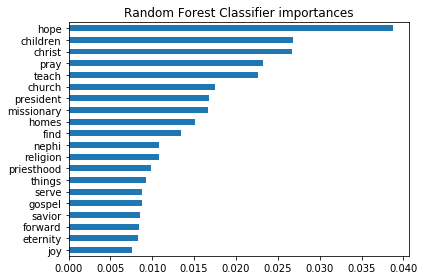

In [20]:
importances[19::-1].plot(kind='barh')
plt.title("Random Forest Classifier importances")
plt.tight_layout()
plt.savefig("rfc_importances.png", dpi=128)
plt.show()